In [1]:
import os
import sys 
import glob
import copy
import pyproj
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import xarray_sentinel
import drama.utils as drtls
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse, cmod5n_forward
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp
# importing from one directory  up
# sys.path.insert(0, "../" )
# from .misc import round_to_hour, angular_difference, calculate_distance

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from velocity_leakage import S1DopplerLeakage

In [2]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
storage_dir = "data_processed/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] # drop outdated
try:
    scenarios.pop(scenarios.index('Aghulas_20200121'))
except:
    pass
scenarios

['Carrib_20231104',
 'Azores_20201127',
 'Hawaii_20201106',
 'Barbedos_20201110',
 'Morroco_20201103',
 'Aghulas_20191110',
 'Iceland_20231107',
 'Scotland_20231109',
 'Aghulas_20190515']

In [3]:
beam_pattern = "phased_array"
az_mask_cutoffs = [10e3, 20e3, 40e3, 60e3, 80e3, 100e3, 130e3, 160e3]


perf_phased_arrays2 = []

for scenario in scenarios:

    perf_phased_arrays = []

    for az_mask_cutoff in az_mask_cutoffs:

        # ----------------------------------------
        files = glob.glob(f"{data_dir+scenario}/*.SAFE")

        observation = S1DopplerLeakage(
            filename=files,    
            # era5_file='era5_winds/era5_wind_202011.nc',
            era5_directory= 'era5_winds/',
            scene_size=25_000,
            az_mask_cutoff=az_mask_cutoff, 
            vx_sat=8000,
            PRF=4,
            resolution_spatial=200,
            length_antenna=3.2,
            beam_pattern=beam_pattern, # ["sinc", "phased_array"]
            _speckle_noise = False
            )
    
        # clipping is performed such that the same data is analysed regardless of choosen az_mask_cutoff
        # else a greater cutoff would analyse a smaller area of interest as more is clipped at the borders
        observation.open_data()
        clip_ref = int(np.max(az_mask_cutoffs)/observation.resolution_spatial)
        clip = clip_ref - int(observation.az_mask_cutoff/observation.resolution_spatial)
        observation.S1_file = observation.S1_file.isel(azimuth_time = slice(clip, -clip -1 ))
        
        observation.querry_era5()
        observation.wdir_from_era5()
        observation.create_dataset()
        observation.create_beam_mask()
        observation.compute_scatt_eqv_backscatter()
        observation.compute_beam_pattern()
        observation.compute_leakage_velocity()
        observation.compute_leakage_velocity_estimate()

        phased_array = observation.data.V_leakage_pulse_rg_subscene
        phased_array_inverted = observation.data.V_leakage_pulse_rg_subscene_inverted
        diff_phased_array = phased_array - phased_array_inverted
        perf_phased_array = np.sqrt(np.nanmean(diff_phased_array**2))
        perf_phased_arrays.append(perf_phased_array)

    perf_phased_arrays2.append(perf_phased_arrays)
            

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Carrib_20231104/5B80_75FE_FCE5_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_wind_202311.nc
Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Carrib_20231104/5B80_75FE_FCE5_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_wind_202311.nc
Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Carrib_20231104/5B80_75FE_FCE5_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_wind_202311.nc
Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Carrib_20231104/5B80_75FE_FCE5_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_wind_202311.nc
Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Carrib_20231104/5B80_75FE_FCE5_res200.nc
Loading 

2024-01-04 09:27:19,857 INFO Welcome to the CDS
2024-01-04 09:27:19,857 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-01-04 09:27:20,014 INFO Request is queued
2024-01-04 09:27:21,073 INFO Request is running
2024-01-04 09:27:24,937 INFO Request is completed
2024-01-04 09:27:24,939 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data5/adaptor.mars.internal-1704356845.7860882-13596-9-ced2e32c-0f7d-4b07-a1b2-ef317ac31cd0.nc to era5_winds/era5_20190515h1700_lat-37_38_lon20_91.nc (3.5K)
2024-01-04 09:27:25,314 INFO Download rate 9.4K/s


Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_20190515h1700_lat-37_38_lon20_91.nc
Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20190515/380C_A15C_E78E_EF27_FA2B_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_20190515h1700_lat-37_38_lon20_91.nc
Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20190515/380C_A15C_E78E_EF27_FA2B_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_20190515h1700_lat-37_38_lon20_91.nc
Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20190515/380C_A15C_E78E_EF27_FA2B_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_20190515h1700_lat-37_38_lon20_91.nc
Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20190515/380C_A15C_E78E_EF27_FA2B_res200.nc
Load

Text(0.5, 0, 'Azimuthal ground footprint cutoff [m]')

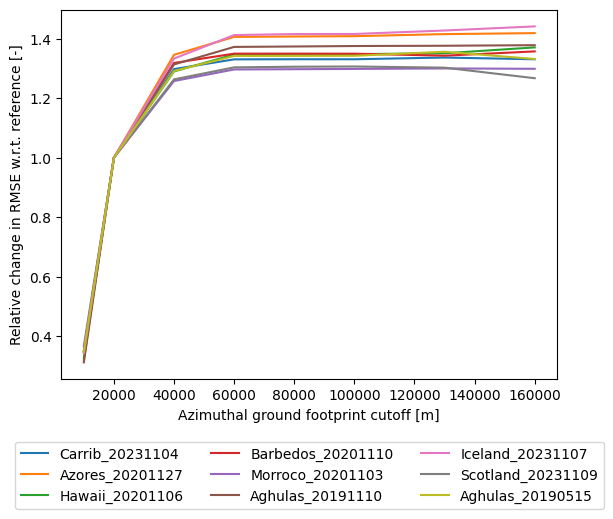

In [4]:
df = pd.DataFrame(perf_phased_arrays2, columns = az_mask_cutoffs, index= scenarios).transpose()
df_divided = df.div(df.iloc[1, :], axis=1)
# df_divided.plot()
ax = df_divided.plot()

# Customize the legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
ax.set_ylabel('Relative change in RMSE w.r.t. reference [-]')
ax.set_xlabel('Azimuthal ground footprint cutoff [m]')


In [5]:
df

,Carrib_20231104,Azores_20201127,Hawaii_20201106,Barbedos_20201110,Morroco_20201103,Aghulas_20191110,Iceland_20231107,Scotland_20231109,Aghulas_20190515
10000.0,0.071697,0.087878,0.090700,0.078893,0.091918,0.070283,0.088865,0.104785,0.136118
20000.0,0.206825,0.276292,0.278143,0.226204,0.250882,0.225644,0.258805,0.297692,0.392222
40000.0,0.268537,0.372000,0.358956,0.298367,0.315654,0.296490,0.345190,0.376197,0.506708
60000.0,0.275301,0.388646,0.374745,0.305446,0.325409,0.309799,0.365627,0.388224,0.526587
80000.0,0.275378,0.389012,0.374974,0.305446,0.325636,0.310119,0.366550,0.388870,0.526658
100000.0,0.275363,0.389329,0.375131,0.305407,0.325864,0.310476,0.366596,0.389107,0.526783
130000.0,0.276565,0.391240,0.375916,0.303896,0.326291,0.310682,0.369609,0.387942,0.532109
160000.0,0.275359,0.392150,0.381424,0.307151,0.325975,0.311122,0.373195,0.377361,0.522565
